In [4]:
libraries = c("rootSolve","ncdf4","dplyr","magrittr","chron","ggplot2","lattice",
              "zoo","RColorBrewer")
for(x in libraries) {
    library(x,character.only=TRUE,warn.conflicts=FALSE) }

# options(jupyter.plot_mimetypes = "image/svg+xml") 
clrs = brewer.pal(8,"Set1")

windowsFonts(Times = windowsFont("Times New Roman"))
base_sz = 11 # base_size parameter

'%&%' <- function(x,y)paste0(x,y)
    
# Initialization of array for recorded plots
plot_point_sizes <- c(); nm <- c(); plot_point_sizes <- list()

In [5]:
# set path and filename
ncpath <- "../data/Rainfall monthly/"
ncname <- "cru_ts4.00.1901.2015.pre.dat"  
ncfname <- paste0(ncpath, ncname, ".nc")
dname <- "pre"

In [6]:
# open a netCDF file
ncin <- nc_open(ncfname)
print(ncin)

File ../data/cru_ts4.00.1901.2015.pre.dat.nc (NC_FORMAT_CLASSIC):

     2 variables (excluding dimension variables):
        float pre[lon,lat,time]   
            long_name: precipitation
            units: mm/month
            correlation_decay_distance: 450
            _FillValue: 9.96920996838687e+36
            missing_value: 9.96920996838687e+36
        int stn[lon,lat,time]   
            description: number of stations contributing to each datum

     3 dimensions:
        lon  Size:720
            long_name: longitude
            units: degrees_east
        lat  Size:360
            long_name: latitude
            units: degrees_north
        time  Size:1380   *** is unlimited ***
            long_name: time
            units: days since 1900-1-1
            calendar: gregorian

    8 global attributes:
        Conventions: CF-1.4
        title: CRU TS4.00 Precipitation
        institution: Data held at British Atmospheric Data Centre, RAL, UK.
        source: Run ID = 1701270

In [7]:
# get longitude and latitude
lon <- ncvar_get(ncin,"lon")
nlon <- dim(lon)
head(lon)

[1] -179.75 -179.25 -178.75 -178.25 -177.75 -177.25

In [8]:
lat <- ncvar_get(ncin,"lat")
nlat <- dim(lat)
head(lat)

[1] -89.75 -89.25 -88.75 -88.25 -87.75 -87.25

In [9]:
print(c(nlon,nlat))

[1] 720 360


In [10]:
# get time
time <- ncvar_get(ncin,"time")

In [11]:
tms = as.Date('1900-1-1') + time

We will be interested in particular location N6.25 E6, so to say, that our lon and lat coordinates will be:

* lat = 6.75° North, we count degrees south starting from -90° of the South pole with step 30'. This gives: $-89.75+0.5\cdot (x-1)=6.75$ $\Rightarrow$ $x = (89.75+6.75)/0.5+1$

In [12]:
x = (89.75+6.75)/.5+1
x

[1] 194

In [13]:
lat[x]

[1] 6.75

* lat = 6° East, and we count degrees east starting from zero, so that: $-179.75+0.5*(y-1)=6.25$ $\Rightarrow$ $y=(179.75+6.25)/0.5+1$

In [14]:
y = (179.75+6.25)/0.5+1
y

[1] 373

In [15]:
# get precipitation
p_array <- ncvar_get(ncin,dname)
dlname <- ncatt_get(ncin,dname,"long_name")
dunits <- ncatt_get(ncin,dname,"units")
fillvalue <- ncatt_get(ncin,dname,"_FillValue")
dim(p_array)

[1]  720  360 1380

In [16]:
# replace netCDF fill values with NA's
p_array[p_array==fillvalue$value] <- NA

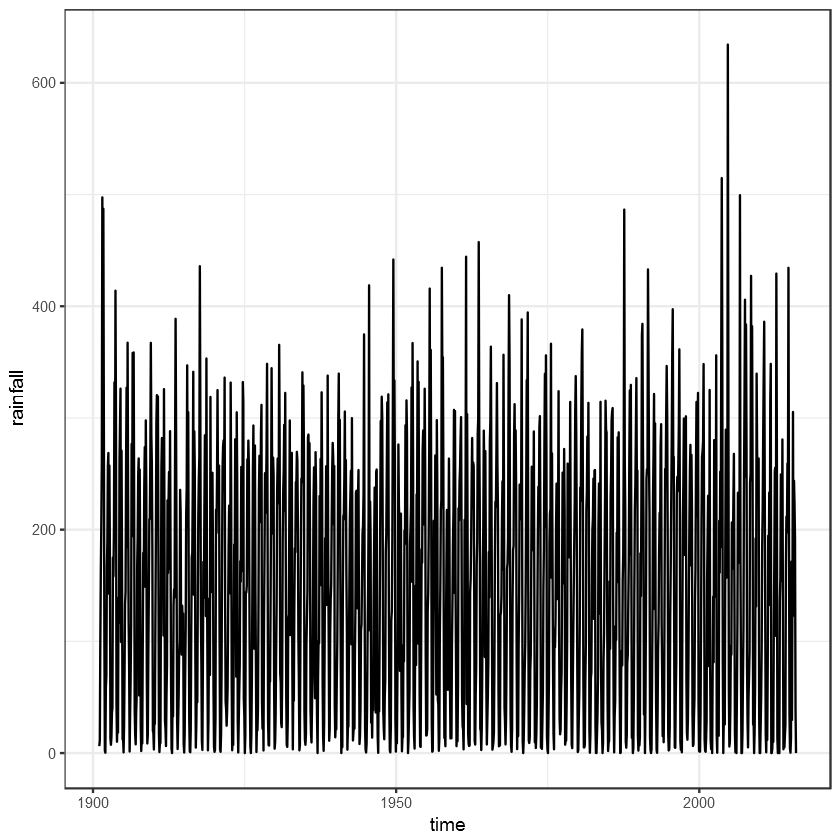

In [17]:
rainfall = data.frame(time=as.Date('1900-1-1')+time,rainfall=p_array[y,x,])

rainfall %>% ggplot() +
    geom_path(aes(x=time,y=rainfall)) +
    theme_bw()

In [18]:
rainfall %>%
    rowwise %>%
    mutate(month = lubridate::month(as.POSIXlt(time)),
          year = lubridate::year(as.POSIXlt(time))) %>%
    ungroup -> rainfall

In [19]:
startRainySeason = function(yr,rainfall_df=rainfall) {
    df_ = rainfall_df %>% filter(year==yr)
    df_ %>% filter(rainfall>=60) %>% 
        filter(month==min(month)) %>% .$month -> minMonth
    if (minMonth==1) {
        return(1)
    } else {
        df_ %>% filter(month==minMonth|month==(minMonth-1)) %>% .$rainfall -> rf
        return(minMonth-1+(60-rf[1])/(rf[2]-rf[1]))
    }
}

endRainySeason = function(yr,rainfall_df=rainfall) {
    df_ = rainfall_df %>% filter(year==yr)
    df_ %>% filter(rainfall>=60) %>% 
        filter(month==max(month)) %>% .$month -> maxMonth
    if (maxMonth==12) {
        df_ %>% filter(month==maxMonth|month==(maxMonth-1)) %>% .$rainfall -> rf
        return(maxMonth+(rf[2]-60)/(rf[1]-rf[2]))
    } else {
        df_ %>% filter(month==maxMonth|month==(maxMonth+1)) %>% .$rainfall -> rf
        return(maxMonth+(60-rf[1])/(rf[2]-rf[1]))
    }
}

In [20]:
rainfall %>% group_by(month) %>%
    summarize(rainfall = mean(rainfall), year=-1) %>% 
    mutate(start = startRainySeason(-1,.), end = endRainySeason(-1,.)) %>%
    select(start,end) %>% 
    unique %>% t %>% cbind(60) %>% as.data.frame -> result_mean_rainfall_NG
colnames(result_mean_rainfall_NG) = c('month','rainfall')
result_mean_rainfall_NG %<>% mutate(point=rownames(.))
result_mean_rainfall_NG

month,rainfall,point
2.558663,60,start
10.934036,60,end


In [21]:
(result_mean_rainfall_NG$month-1)/12

[1] 0.1298886 0.8278363

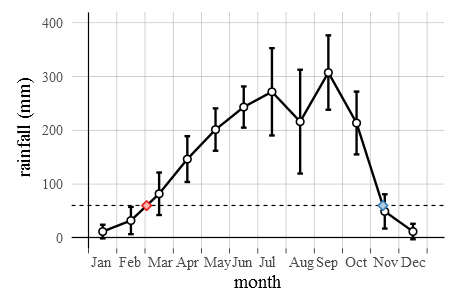

In [22]:
cs = c(3.8,2.5)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

rainfall %>% group_by(month) %>% 
    summarize(mean = mean(rainfall), se = sd(rainfall)) -> rainfall_NG_mean

pd = position_dodge(0.1)
rainfall_NG_mean %>% 
    mutate(month=month+.5) %>%
    ggplot(aes(x=month,y=mean)) + 
        geom_hline(yintercept=0,size=.25,color="black") +
        geom_hline(yintercept=60,size=.25,linetype=2,color="black") +
        geom_vline(xintercept=1,size=.25,color="black") +
        geom_errorbar(aes(ymin=mean-se, ymax=mean+se), colour="black", width=.2, position=pd) +
        geom_line(position=pd,linetype=1) +
        geom_point(position=pd,fill="white",shape = 21) +
        geom_point(data=result_mean_rainfall_NG,
                   aes(x=month+.5,y=rainfall,
                       color=as.factor(rownames(result_mean_rainfall_NG)),
                       fill=as.factor(rownames(result_mean_rainfall_NG))),
                   pch=23,size=1.8) +
        guides(fill=FALSE,color=FALSE) +
        scale_fill_manual(values=brewer.pal(8,"Pastel1")[c(1,2)]) + 
        scale_color_manual(values=brewer.pal(8,"Set1")[c(1,2)]) + 
        theme_minimal(base_size=base_sz,base_family='Times') +
        theme(
          panel.grid.major.x = element_line(colour = "grey",size=.15), 
          panel.grid.major.y = element_line(colour = "grey",size=.15),
          panel.grid.minor = element_blank(),
            axis.ticks.x=element_line(size=.15),
          axis.text.x=element_text(hjust=-.1), 
          plot.margin = unit(c(.5,.5,.5,.75),"lines")) +
        coord_cartesian(xlim=c(1,13),ylim=c(0,400)) + #expand=0.01,
        scale_x_continuous(breaks = 1:13,labels=c(month.abb[1:12],"")) +
        labs(x="month",y="rainfall (mm)") -> p
p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../results/rainfall1.pdf", useDingbats=FALSE)

In [23]:
rainfall_NG_mean %>% summary

     month            mean              se       
 Min.   : 1.00   Min.   : 11.72   Min.   :12.70  
 1st Qu.: 3.75   1st Qu.: 44.92   1st Qu.:30.26  
 Median : 6.50   Median :173.89   Median :39.46  
 Mean   : 6.50   Mean   :148.86   Mean   :45.78  
 3rd Qu.: 9.25   3rd Qu.:222.86   3rd Qu.:61.07  
 Max.   :12.00   Max.   :307.38   Max.   :96.52  

In [24]:
148.86*12

[1] 1786.32

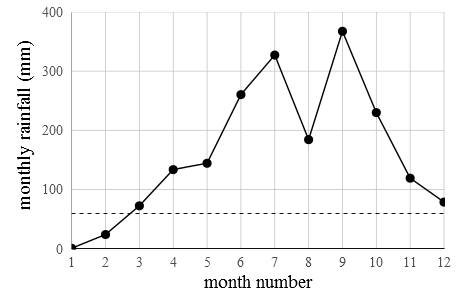

In [25]:
rainfall %>% filter(year==1905) -> df

df %>%
    ggplot(aes(x=month,y=rainfall)) + 
        geom_hline(yintercept=0,size=.2,color="black") +
        geom_hline(yintercept=60,size=.2,linetype=2,color="black") +
        geom_vline(xintercept=1,size=.2,color="black") +
        geom_point(position=pd) +
        geom_line(position=pd,size=.3,linetype=1) +
        theme_minimal(base_size=base_sz,base_family='Times') +
        theme(
          panel.grid.major = element_line(colour = "grey",size=.15),
          panel.grid.minor = element_blank(),
          plot.margin = unit(c(.5,.5,.5,.75),"lines")) +
        coord_cartesian(expand=0,xlim=c(1,12),ylim=c(0,400)) + 
        scale_x_continuous(breaks = 1:12) +
        labs(x="month number",y="monthly rainfall (mm)")



In [26]:
yrs = data.frame(year=rainfall$year %>% unique)
yrs %>% rowwise %>%
    mutate(start = startRainySeason(year), end = endRainySeason(year)) %>%
    mutate(startingWeek = floor((start-.5)*52/12+1), endingWeek = floor((end-.5)*52/12+1)) %>% 
    rowwise %>% 
    mutate(endingWeek=ifelse(endingWeek>52,52,endingWeek)) %>% 
    ungroup -> df

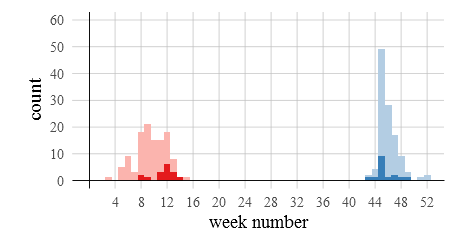

In [42]:
cs = c(3.8,2)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

df %>% ggplot() +
    geom_bar(aes(startingWeek),fill=brewer.pal(8,"Pastel1")[1]) +
    geom_bar(aes(endingWeek),fill=brewer.pal(8,"Pastel1")[2]) +
    geom_bar(data=filter(df,year>=2000),aes(startingWeek),fill=brewer.pal(8,"Set1")[1]) +
    geom_bar(data=filter(df,year>=2000),aes(endingWeek),fill=brewer.pal(8,"Set1")[2]) +
    coord_cartesian(xlim=c(0,52),ylim=c(0,60),expand=0.01) + 
    geom_hline(yintercept=0,size=.2,color="black") +
    geom_vline(xintercept=0,size=.2,color="black") +
    theme_minimal(base_size=base_sz,base_family='Times') +
    theme(
      panel.grid.major.y = element_line(colour = "grey",size=.15),
      panel.grid.major.x = element_line(colour = "grey",size=.15),
      panel.grid.minor = element_blank(),
      plot.margin = unit(c(.5,.5,.5,1.2),"lines")) +
    scale_x_continuous(breaks = seq(4,52,by=4)) +
    scale_y_continuous(breaks = seq(0,60,by=10)) +
    labs(x="week number",y="count") -> p
p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../results/rainfall2.pdf", useDingbats=FALSE)

In [43]:
summary(df)

      year          start            end         startingWeek   
 Min.   :1901   Min.   :1.000   Min.   :10.27   Min.   : 3.000  
 1st Qu.:1930   1st Qu.:2.322   1st Qu.:10.80   1st Qu.: 8.000  
 Median :1958   Median :2.577   Median :10.90   Median :10.000  
 Mean   :1958   Mean   :2.598   Mean   :11.00   Mean   : 9.565  
 3rd Qu.:1986   3rd Qu.:3.023   3rd Qu.:11.18   3rd Qu.:11.000  
 Max.   :2015   Max.   :3.823   Max.   :12.46   Max.   :15.000  
   endingWeek   
 Min.   :43.00  
 1st Qu.:45.00  
 Median :46.00  
 Mean   :45.98  
 3rd Qu.:47.00  
 Max.   :52.00  

# The same for Tanzania

We will be interested in particular location that is close to 6°51'S 37°38'E (that is 6.85°S, 37.63°E)

* lat = -6.75°S North that gives: $-89.75+0.5\cdot(x-1)=-6.75$ $\Rightarrow$ $x = (89.75-6.75)/0.5+1$

In [29]:
x = (89.75-6.75)/0.5+1
x

[1] 167

In [30]:
lat[x]

[1] -6.75

* lon = 37.63°E, and we count degrees east starting from zero, so that: $-179.75+0.5\cdot(y-1)=37.75$ $\Rightarrow$ $y=(179.75+37.75)/0.5+1$

In [31]:
y = (179.75+37.75)/0.5+1
y

[1] 436

In [32]:
lon[y]

[1] 37.75

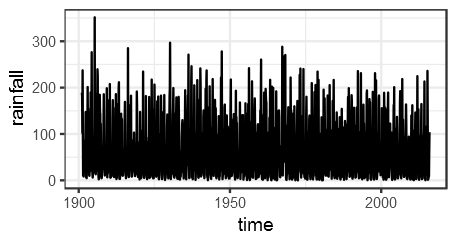

In [33]:
rainfall_TZ = data.frame(time=as.Date('1900-1-1')+time,rainfall=p_array[y,x,])

rainfall_TZ %>% ggplot() +
    geom_path(aes(x=time,y=rainfall)) +
    theme_bw()

In [34]:
rainfall_TZ %<>%
    rowwise %>%
    mutate(month = lubridate::month(as.POSIXlt(time)),
          year = lubridate::year(as.POSIXlt(time))) %>%
    ungroup

In [35]:
endRainySeason_TZ = function(yr,rainfall_df=rainfall_TZ) {
    df_ = rainfall_df %>% filter(year==yr)
    df_ %>% filter(rainfall<60) %>% 
        filter(month==min(month)) %>% .$month -> minMonth
    if (minMonth==1) {
        return(1)
    } else {
        df_ %>% filter(month==minMonth|month==(minMonth-1)) %>% .$rainfall -> rf
        return(minMonth-1+(60-rf[1])/(rf[2]-rf[1]))
    }
}

startRainySeason_TZ = function(yr,rainfall_df=rainfall_TZ) {
    df_ = rainfall_df %>% filter(year==yr)
    df_ %>% filter(rainfall<60) %>% 
        filter(month==max(month)) %>% .$month -> maxMonth
    if (maxMonth==12) {
        df_ %>% filter(month==maxMonth|month==(maxMonth-1)) %>% .$rainfall -> rf
        return(maxMonth+(rf[2]-60)/(rf[1]-rf[2]))
    } else {
        df_ %>% filter(month==maxMonth|month==(maxMonth+1)) %>% .$rainfall -> rf
        return(maxMonth+(60-rf[1])/(rf[2]-rf[1]))
    }
}

In [36]:
rainfall_TZ %>% group_by(month) %>%
    summarize(rainfall = mean(rainfall), year=-1) %>% 
    mutate(start = startRainySeason_TZ(-1,.), end = endRainySeason_TZ(-1,.)) %>%
    select(start,end) %>% 
    unique %>% t %>% cbind(60) %>% as.data.frame -> result_mean_rainfall_TZ
colnames(result_mean_rainfall_TZ) = c('month','rainfall')
result_mean_rainfall_TZ %<>% mutate(point=rownames(.))
result_mean_rainfall_TZ

month,rainfall,point
11.190995,60,start
5.155782,60,end


In [37]:
(result_mean_rainfall_TZ$month-1)/12

[1] 0.8492496 0.3463152

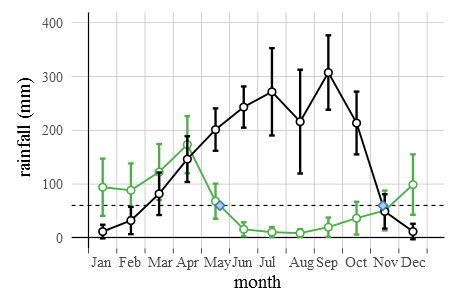

In [38]:
cs = c(3.8,2.5)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

pd = position_dodge(0.1)

clr_TZ = brewer.pal(8,"Set1")[3]
clr_NG = "black" #brewer.pal(8,"Set1")[4]

rainfall_TZ %>% group_by(month) %>% 
    summarize(mean = mean(rainfall), se = sd(rainfall)) -> rainfall_TZ_mean

rainfall_TZ_mean %>%
    ggplot(aes(x=month+.5,y=mean)) + 
        geom_hline(yintercept=0,size=.25,color="black") +
        geom_hline(yintercept=60,size=.25,linetype=2,color="black") +
        geom_vline(xintercept=1,size=.25,color="black") +
        geom_errorbar(aes(ymin=mean-se, ymax=mean+se), linetype=1, colour=clr_TZ, width=.2, position=pd) +
        geom_line(position=pd,size=.4,linetype=1,color=clr_TZ) +
        geom_line(data=rainfall_NG_mean,position=pd,size=.4,linetype=1,color=clr_NG) +
        geom_point(position=pd,fill="white",shape = 21,color=clr_TZ) +
        geom_errorbar(data=rainfall_NG_mean, aes(ymin=mean-se, ymax=mean+se), 
                      colour=clr_NG, width=.2, position=pd) +
        geom_point(data=rainfall_NG_mean,position=pd,fill="white",shape = 21,color=clr_NG) +
        geom_point(data=filter(rbind(result_mean_rainfall_NG,result_mean_rainfall_TZ),point=='end'),
                   aes(y=rainfall),
                   color=brewer.pal(8,"Set1")[2], fill=brewer.pal(8,"Pastel1")[2],
                   pch=23,size=1.8) +
        guides(fill=FALSE,color=FALSE) +
        theme_minimal(base_size=base_sz,base_family='Times') +
        theme(
          axis.ticks.x=element_line(size=.15),
          panel.grid.major.x = element_line(colour = "grey",size=.15), 
          panel.grid.major.y = element_line(colour = "grey",size=.15),
          panel.grid.minor = element_blank(),
          axis.text.x=element_text(hjust=-.1), 
          plot.margin = unit(c(.5,.5,.5,.75),"lines")) +
        coord_cartesian(expand=0.01,xlim=c(1,13),ylim=c(0,400)) + 
        scale_x_continuous(breaks = 1:13,labels=c(month.abb[1:12],"")) +
        labs(x="month",y="rainfall (mm)") -> p
p

ggsave(plot=p,width=cs[1],height=cs[2],filename="../results/rainfall3.pdf", useDingbats=FALSE)

In [39]:
rainfall_TZ_mean$mean

[1]  94.133044  88.475654 122.468698 173.360873  68.126958  15.958261
 [7]  10.666957   8.862609  19.887827  36.631305  50.778262  99.060872

In [40]:
rainfall_NG_mean$mean

[1]  11.71826  32.20435  81.95826 146.44696 201.33391 243.22435 271.55566
 [8] 216.07218 307.37913 213.54087  49.15652  11.76174

In [46]:
nc_close(ncin)